This notebook is adapted from the [Jupyter notebook by Savaris et al.](https://gist.github.com/rsavaris66/eccfc6caf4c9578d676c134fac74d3fe)

As the original notebook does not contain a license, it is reproduced here under Fair Use exemptions (resp. §51 UrhG). 
All modifications are put into the public domain.

Changes compared to original version by Savaris et al.:

- put `import`s at top
- remove unnecessary `import`s
- remove unnecessary debugging prints (e.g., `df.columns` to verify whether the imported data has correct schema)
- comment out code that writes intermediate tables to Excel files (`##`)
- add comments (preceeded by `#!#` to add further information
- add a helper function to plot time series for countries
- directly import data from published Excel file
- change plotting code for heatmap to more closely resemble Figure 2 in the paper

As Savaris et al. aggregate mobility and mortality on a weekly basis before comparing countries to each other, the example datasets only contain weekly data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

In [2]:
#!# Select one of the datasets by changing the "selected" variable
datasets = [('datasets/Compiled data Tables 1, 2.xlsx', 'DataForScript_CovidSavaris'), ## 0 - Data used by Savaris et al.
            ('datasets/CovidSavaris_Test_only_random.xlsx',), ## 1 - Five countries with random mobility/mortality
            ('datasets/CovidSavaris_Test_only_working_lockdown_with_wobble.xlsx',), ## 2 - Five hypothetical countries that demonstrate an effect of lockdowns
            ('datasets/CovidSavaris_Test_Savaris_PoC.xlsx',), ## 3 - Dataset provided by R.F. Savaris on request
            ('datasets/CovidSavaris_Test_Savaris_PoC_noisy.xlsx',) ## 4 - Dataset provided by R.F. Savaris on request with additional noise applied
           ]

selected = 0
df = pd.read_excel(*datasets[selected])

In [3]:
#!# Optional: replace incorrect timestamps in source data
if True:
    f13 = pd.Timestamp('2020-01-03 00:00:00')
    f31 = pd.Timestamp('2020-03-01 00:00:00')

    f23 = pd.Timestamp('2020-02-03 00:00:00')
    f32 = pd.Timestamp('2020-03-02 00:00:00')
    df = df.replace(f13,f31).replace(f23,f32)
    ## print(len(df[df['date'] == f13]))

In [4]:
## helper function
def plot_country(country):
        data = df[df['location'] == country]
        day = data['date'].values
        mortality = data['new_deaths_per_million'].values
        mobility = data['Stay-at-home'].values
        plt.figure(figsize=(10,3))
        plt.plot(day, mobility)
        plt.plot(day, mortality)
        plt.ylabel("decrease in mobility compared to baseline (blue)\ndeaths per million (orange)")
        plt.xlabel("date")
        plt.title(country)
        plt.show()

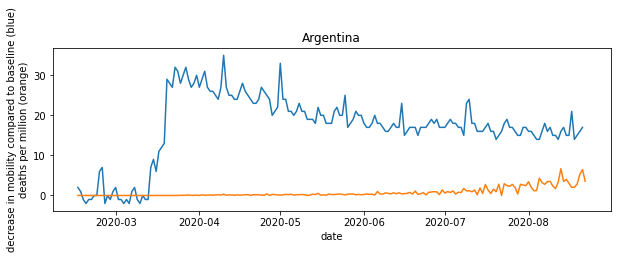

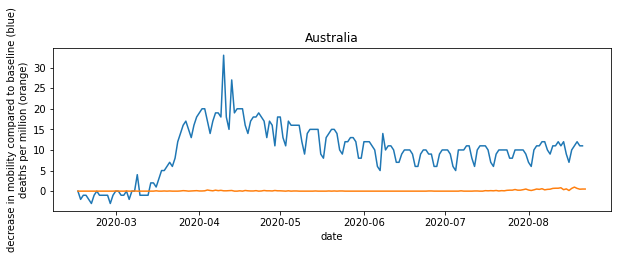

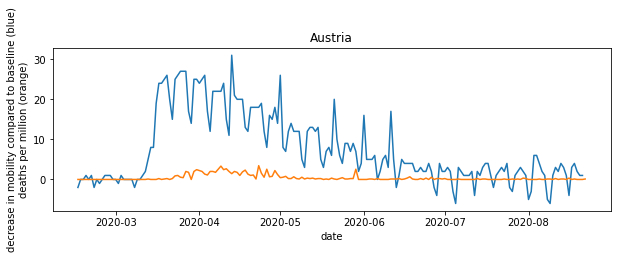

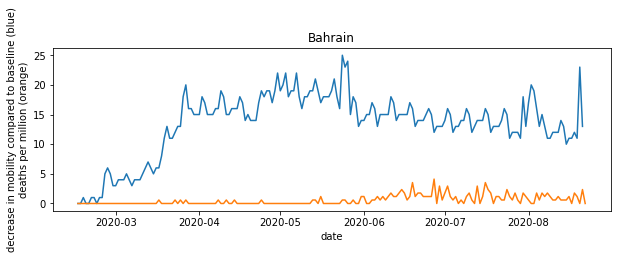

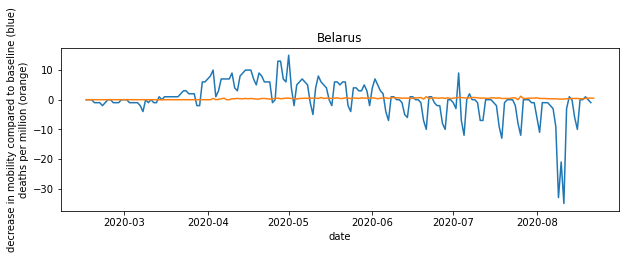

In [5]:
#!# Optional. print data for first five countries in dataset
for country in sorted(list(set(df['location'].values)))[:5]: # print max 5 countries for performance reasons
    plot_country(country)

In [6]:
#!# This code block aggregates mobility/mortality data by week
#!# and calculates the relative change compared to the previous week

location = df['location'][0]
epiweek = df['epi-week'][0]
primeirasemana = df['epi-week'][0] ## first week
sum_of_death_million_epi_week = 0.0
mean_stay_at_home_epi_week = 0.0

smooth_death_M = 0.0
smooth_stay_at_home = 0.0

cont = 0

for i in range(df.shape[0]):
    
    #When the week or the country changes, the totals are save as new columns in the last line of the epi-week
    if (df['epi-week'][i] != epiweek or df['location'][i] != location):
        if (df['location'][i] != location):              
            primeirasemana = df['epi-week'][i]                   
        
        df.loc[i - 1, 'sum of death/million/epi-week'] = sum_of_death_million_epi_week
        df.loc[i - 1, 'mean stay-at-home/epi-week'] = mean_stay_at_home_epi_week / cont
        
        #Smooth Death/M and Smooth Stay-at-Home cannot be calculated in the first week of the country 
        if (epiweek > (primeirasemana)):
            df.loc[i - 1, 'Smooth Death/M', ] = sum_of_death_million_epi_week - smooth_death_M     
            df.loc[i - 1, 'Smooth Stay-at-Home'] = (mean_stay_at_home_epi_week / cont) - smooth_stay_at_home 
        
         
        smooth_death_M = sum_of_death_million_epi_week
        smooth_stay_at_home = mean_stay_at_home_epi_week / cont
        
        sum_of_death_million_epi_week = 0.0
        mean_stay_at_home_epi_week = 0.0
        cont = 0
        location = df['location'][i]
        epiweek = df['epi-week'][i]          
    
    #Total values per day and ignore when value is not given
    if (math.isnan(float(df.loc[i, 'new_deaths_per_million'])) == False):
        sum_of_death_million_epi_week += float(df.loc[i, 'new_deaths_per_million'])
    if (math.isnan(float(df.loc[i, 'Stay-at-home'])) == False):
        mean_stay_at_home_epi_week += float(df.loc[i, 'Stay-at-home'])        
        cont += 1

df.loc[i, 'sum of death/million/epi-week'] = sum_of_death_million_epi_week 
df.loc[i, 'mean stay-at-home/epi-week'] = mean_stay_at_home_epi_week / cont
## The fields "Smooth Stay-at-Home" and "Smooth Death/M" actually store the derivative, i.e. the change to the previous week
if (smooth_death_M > 0):
    df.loc[i, 'Smooth Death/M', ] = sum_of_death_million_epi_week - smooth_death_M 

if (smooth_stay_at_home > 0): ## why only if > 0 ? Can also be < 0, right?
    df.loc[i, 'Smooth Stay-at-Home'] = (mean_stay_at_home_epi_week / cont) - smooth_stay_at_home     

# Save results in the file
## df.to_excel(r'CovidSavaris_Python.xlsx')

In [7]:
##df = pd.read_excel('CovidSavaris_Python.xlsx')
##df['mean stay-at-home/epi-week'].notnull()

### From here on, the script only uses weekly aggregates

In [8]:
#Read the data generated in the previous section
##df = pd.read_excel('CovidSavaris_Python.xlsx')
# Remove blank lines in the column "mean stay-at-home/epi-week", leaving just the mean of the epidemiologic week  
df_dadossemana = df[df['mean stay-at-home/epi-week'].notnull()]
##df_dadossemana.iloc[:, 2:]

In [9]:
#!# This code block compares each country(/region) to each other by
#!# subtracting the mobility/mortality data of country 1 from that of
#!# country 2, and then calculating the regression.

#Select all countries and regions from the dataframe
locations = df_dadossemana['location'].unique()
tabelacompleta = pd.DataFrame()
linha = 0
df.dropna() #!# does not have any effect as parameter "inplace" is False by default

#Makes the interaction among regions
for i in locations:
    df_paisum = df_dadossemana[df_dadossemana['location'] == i].reset_index()
    
    ## If I want to select only one country, remove "#" from the lines 
    #Se eu quero selecionar só um país, retirar "#" das linhas 
    #if (i != 'Canada'):
    #    continue
    
    #For each country, compare to all others
    for j in locations:        
        
        #if (j != 'Australia'):
        #    continue
        
        #Do not compare a region to itself
        if (i == j):
            continue
            
        df_paisdois = df_dadossemana[df_dadossemana['location'] == j].reset_index()         
        tabela = pd.DataFrame()

        #Create a table with all epidemiological weeks
        for k in range(df_paisdois.shape[0]):            
            
            #Subtract death from region A from region B
            tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Death'] = float(df_paisum['Smooth Death/M'][k]) - float( df_paisdois['Smooth Death/M'][k])            
            
            #Subtrai o Stay at Home do pais A pelo pais B
            tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Stay'] = float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])
            
            #tabela.loc[k, df_paisum['location'][k] + ' Death'] = df_paisum['Smooth Death/M'][k]            
            #tabela.loc[k, df_paisdois['location'][k] + ' Death'] = df_paisdois['Smooth Death/M'][k]            
            #tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Death'] = float(df_paisum['Smooth Death/M'][k]) - float( df_paisdois['Smooth Death/M'][k])            
            #tabela.loc[k, '(' + df_paisum['location'][k] + ' - ' + df_paisdois['location'][k] + ') Stay'] = float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])            
            #tabela.loc[k, df_paisum['location'][k] + ' Stay'] = df_paisum['Smooth Stay-at-Home'][k]            
            #tabela.loc[k, df_paisdois['location'][k] + ' Stay'] = df_paisdois['Smooth Stay-at-Home'][k]            
            #print('{0} {1} {2}'.format(float(df_paisum['Smooth Stay-at-Home'][k]) , float( df_paisdois['Smooth Stay-at-Home'][k]), float(df_paisum['Smooth Stay-at-Home'][k]) - float( df_paisdois['Smooth Stay-at-Home'][k])))
            
        #Ignore the 8th week    
        tabela = tabela.dropna()
        X = tabela.iloc[:, 1:2].values # Stay
        x = sm.add_constant(X) #
        y = tabela.iloc[:, 0:1] # (Argentina - Australia) Death 
    
        res = sm.OLS(y,x).fit() #Create and adjust the model
        
        #Generate the tables with statistical values obtaiend from the comparison
        tabelacompleta.loc[linha, 'Location_A'] = df_paisum['location'][1]
        tabelacompleta.loc[linha, 'Location_B'] = df_paisdois['location'][1]
        tabelacompleta.loc[linha, 'A Death - B Death'] =  df_paisum['location'][1] + ' - ' + df_paisdois['location'][1]
        tabelacompleta.loc[linha, 'p_const'] = res.pvalues[0]
        tabelacompleta.loc[linha, 'p_x1'] = res.pvalues[1]
        tabelacompleta.loc[linha, 'coef_const'] = res.params[0]
        tabelacompleta.loc[linha, 'coef_x1'] = res.params[1]
        tabelacompleta.loc[linha, 'rsquared'] = res.rsquared    
        tabelacompleta.loc[linha, 'rsquared_adj'] = res.rsquared_adj 
        linha += 1
## tabelacompleta.to_excel(r'Regression.xlsx')        

In [10]:
#Read the data generated from previous step
## tabelacompleta = pd.read_excel('Regression.xlsx')
#Ordena pelo menor valor de p
tabOrdenada = tabelacompleta.sort_values(by=['p_x1']).reset_index()    
for i in range(tabelacompleta.shape[0]):
    #Calculate the FDR(False  DiscoveryRate) by Benjamini  &  Hochberg         
    if (int(tabOrdenada.shape[0]) - (i + 1) > 0):
        tabOrdenada.loc[i, 'FDR B-H'] = float(tabOrdenada['p_x1'][i]) * (int(tabOrdenada.shape[0]) /(int(tabOrdenada.shape[0]) - (i + 1)))

#List from small to big    
tabelacompleta = tabOrdenada.sort_values(by=['A Death - B Death']).reset_index()        
# Week 9   
# Get -0.0398
# p 0.6
#Save the result in Excel 
##tabelacompleta.iloc[:,3:].to_excel(r'Regression_FDR.xlsx')

In [11]:
## tabelacompleta.head(10)

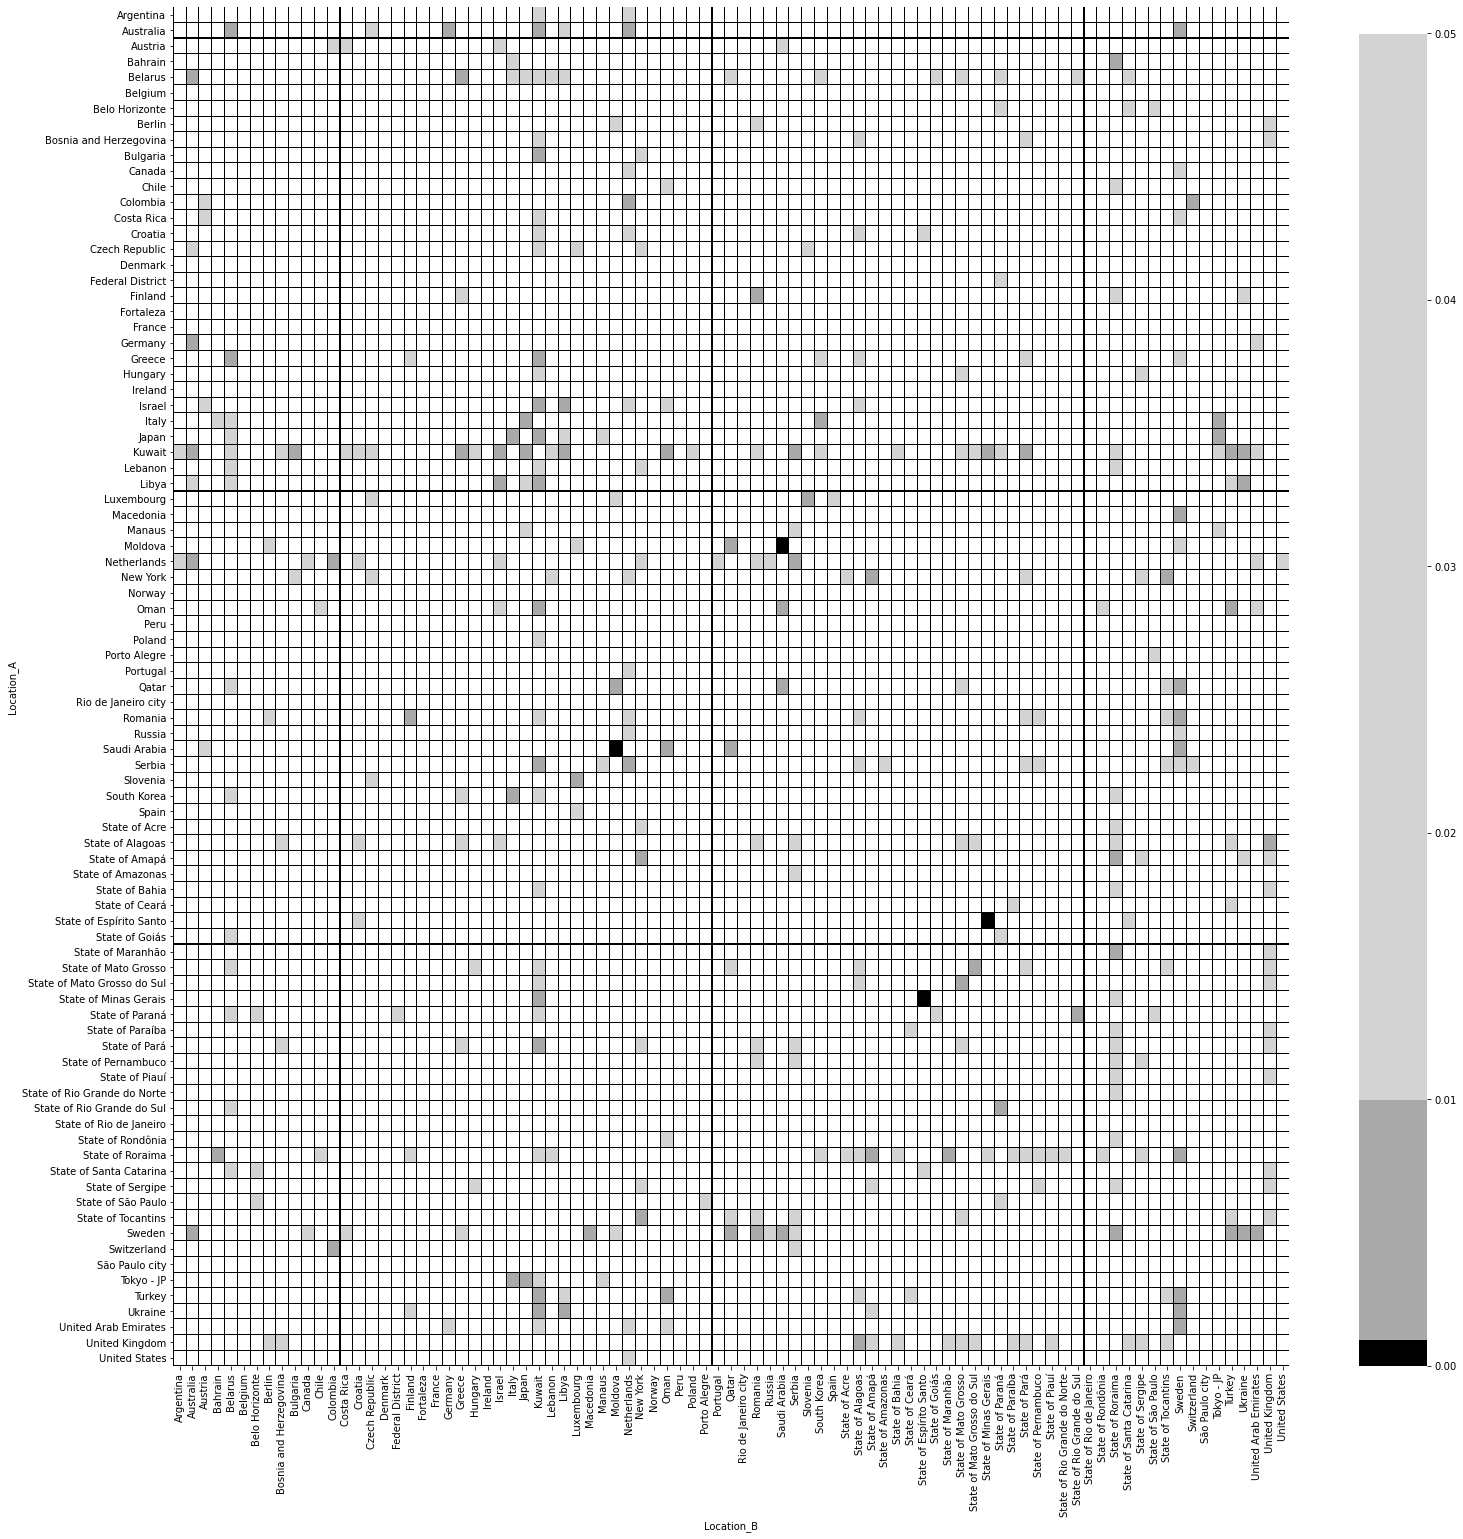

In [12]:
#!# added colormap that resembles that of Figure 2 in the paper
from matplotlib import colors
cmap = colors.ListedColormap(['black']+['darkgray']*9 + ['lightgray']*40 + ['white'], name='abcd', N=51)

#tabelacompleta = pd.read_excel('Regression_FDR.xlsx')

dados = tabelacompleta.pivot("Location_A", "Location_B", "p_x1") ## "dados" == "data"


#!# adapted to accomodate different numbers of countries
if len(set(df['location'].values)) > 5:
    plt.figure(figsize=(25,25))
    fig = sns.heatmap(dados, robust=True, fmt=".4f", cmap=cmap, vmin=0, vmax=0.051, linewidths=.05, linecolor='black', annot=False)
else:
    plt.figure(figsize=(11.1,10))
    fig = sns.heatmap(dados, robust=True, fmt=".4f", cmap=cmap, vmin=0, vmax=0.051, linewidths=.05, linecolor='black', annot=True, annot_kws={"size": 16})


## fig = sns.heatmap(dados, robust=True, fmt="f", cmap='RdBu_r', vmin=0, vmax=0.05, annot=True)
#fig = sns.heatmap(dados, robust=True, fmt="f", cmap=cmap, vmin=0, vmax=0.051, annot=True)
##fig = sns.heatmap(dados, robust=True, fmt=".4f", cmap=cmap, vmin=0, vmax=0.051, linewidths=.05, linecolor='black', annot=True, annot_kws={"size": 16})

plt.savefig('heatmap_PDF.pdf', format='pdf')

In [13]:
## dados.to_excel('DadosPivot.xlsx')